In [1]:
# Versão do Python
from platform import python_version
print('Versão do python Usada:', python_version())

Versão do python Usada: 3.9.20


In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Imports para manipulação de imagens
import os
import cv2
import itertools
import shutil
import imageio
import skimage
import skimage.io
import skimage.transform
from pathlib import Path

# Imports para Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.metrics import binary_accuracy

# Imports para cálculo de métricas e outras tarefas
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Supress de warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

sklearn   : 1.5.2
platform  : 1.0.8
skimage   : 0.24.0
keras     : 3.6.0
matplotlib: 3.9.2
numpy     : 2.0.2
pandas    : 2.2.3
imageio   : 2.36.0
tensorflow: 2.18.0
cv2       : 4.10.0



In [5]:
import tensorflow as tf

print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

GPUs disponíveis: []


## Coletando e Compreendendo os Dados de Imagens de Pulmões Saudáveis e Doentes

**Conjunto de raios-X do Condado de Montgomery**: As imagens de raios-X deste conjunto de dados foram adquiridas no programa de controle da tuberculose do Departamento de Saúde e Serviços Humanos do Condado de Montgomery, MD, EUA. Este conjunto contém 138 radiografias póstero-anteriores, das quais 80 radiografias são normais e 58 radiografias são anormais com manifestações de tuberculose. Todas as imagens são anônimas e estão disponíveis no formato PNG. O conjunto de dados inclui leituras de radiologia disponíveis como arquivo de texto.

**Conjunto de raios X do Hospital de Shenzhen**: As imagens de raios X deste conjunto de dados foram coletadas pelo Hospital de Shenzhen em Shenzhen, providência em Guangdong, China. Os raios X foram adquiridos como parte dos cuidados de rotina no Hospital de Shenzhen. O conjunto contém imagens no formato PNG. Existem 326 radiografias normais e 336 radiografias anormais, mostrando várias manifestações de tuberculose. 

Fonte de Dados:

https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#tuberculosis-image-data-sets



## Definindo o Local de Armazenamento das Imagens

In [6]:
# Diretórios para os 2 grupos de imagens
imagens_shen = 'dados/ChinaSet_AllFiles/CXR_png/'
imagens_mont = 'dados/MontgomerySet/CXR_png/'

In [7]:
# Print do tamanho de cada pasta
print(len(os.listdir(imagens_shen)))
print(len(os.listdir(imagens_mont)))

663
139


In [8]:
# Grava a lista de imagens em cada pasta
shen_image_list = os.listdir(imagens_shen)
mont_image_list = os.listdir(imagens_mont)

## Preparando e Carregando as Imagens de Raio-X

In [9]:
df_shen = pd.DataFrame(shen_image_list, columns = ['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns = ['image_id'])

In [10]:
# Remove da lista o nome 'Thumbs.db'
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

In [11]:
# Reset do índice
df_shen.reset_index(inplace = True, drop = True)
df_mont.reset_index(inplace = True, drop = True)

In [12]:
# Print do Shape
print(df_shen.shape)

(662, 1)


In [13]:
# Print do Shape
print(df_mont.shape)

(138, 1)


In [14]:
# Visualiza os dados
df_shen.head()

,image_id
0,CHNCXR_0001_0.png
1,CHNCXR_0002_0.png
2,CHNCXR_0003_0.png
3,CHNCXR_0004_0.png
4,CHNCXR_0005_0.png


In [15]:
# Visualiza os dados
df_mont.head()

,image_id
0,MCUCXR_0001_0.png
1,MCUCXR_0002_0.png
2,MCUCXR_0003_0.png
3,MCUCXR_0004_0.png
4,MCUCXR_0005_0.png


## Extraindo a Variável Target

In [16]:
# Extração da Variável Target

def extrair_target(x):
    
    target = int(x[-5])
    
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculose'

In [17]:
# Adicionando label aos dataframe
df_shen['target'] = df_shen['image_id'].apply(extrair_target)
df_mont['target'] = df_mont['image_id'].apply(extrair_target)

In [18]:
# Visualiza os dados
df_shen.head()

,image_id,target
0,CHNCXR_0001_0.png,Normal
1,CHNCXR_0002_0.png,Normal
2,CHNCXR_0003_0.png,Normal
3,CHNCXR_0004_0.png,Normal
4,CHNCXR_0005_0.png,Normal


In [19]:
# Visualiza os dados
df_mont.head()

,image_id,target
0,MCUCXR_0001_0.png,Normal
1,MCUCXR_0002_0.png,Normal
2,MCUCXR_0003_0.png,Normal
3,MCUCXR_0004_0.png,Normal
4,MCUCXR_0005_0.png,Normal


In [20]:
# Shenzen Dataset
df_shen['target'].value_counts()

target
Tuberculose    336
Normal         326
Name: count, dtype: int64

In [21]:
# Montgomery Dataset
df_mont['target'].value_counts()

target
Normal         80
Tuberculose    58
Name: count, dtype: int64

## Visualizando as Imagens

In [22]:
# Função para visualizar as imagens
def visualiza_images(col_name, figure_cols, df, caminho_imagens):

    categories = (df.groupby([col_name])[col_name].nunique()).index
    
    f, ax = plt.subplots(nrows = len(categories), 
                         ncols = figure_cols, 
                         figsize = (4 * figure_cols, 4 * len(categories))) 
    
    for i, cat in enumerate(categories):
        
        sample = df[df[col_name] == cat].sample(figure_cols) 
        
        for j in range(0, figure_cols):
            
            file = caminho_imagens + sample.iloc[j]['image_id']
            
            # Lê a imagem do disco
            im = imageio.imread(file)
            
            ax[i, j].imshow(im, resample = True, cmap = 'gray')
            ax[i, j].set_title(cat, fontsize = 14)  
            
    plt.tight_layout()
    plt.show()

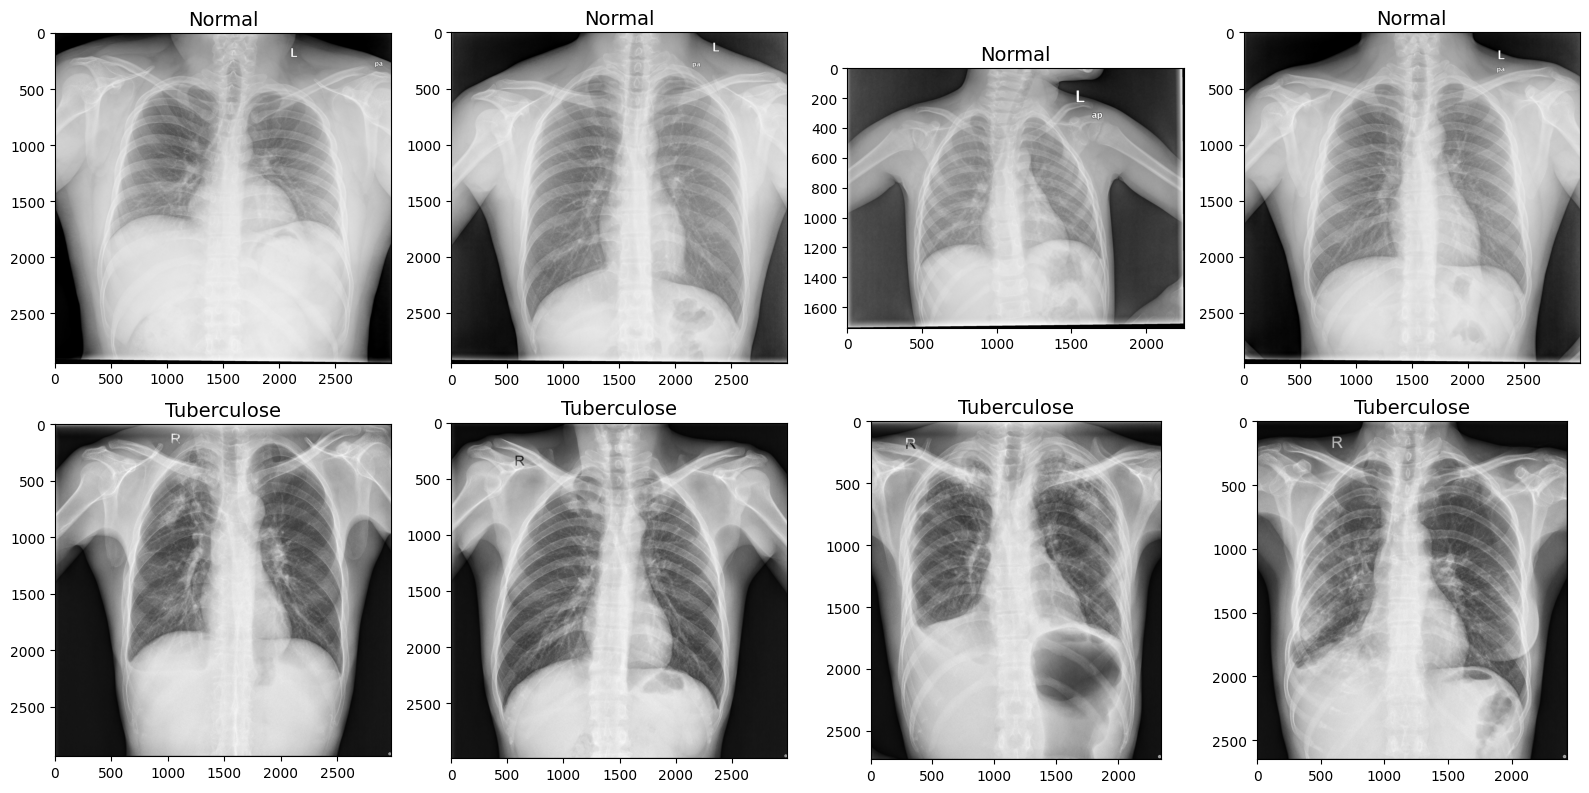

In [23]:
# Shenzen Dataset
visualiza_images('target', 4, df_shen, imagens_shen)

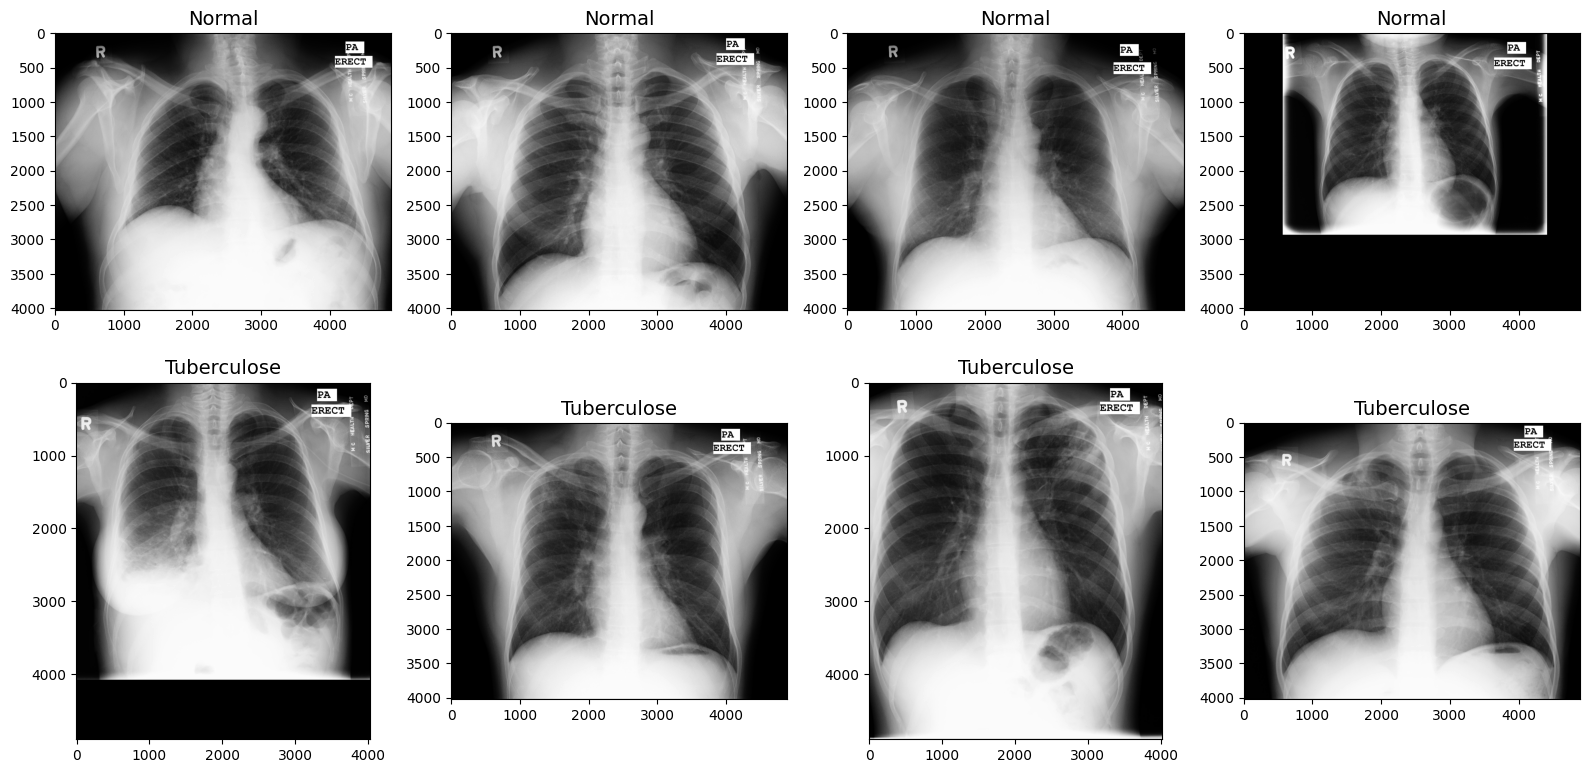

In [24]:
# Montgomery Dataset
visualiza_images('target', 4, df_mont, imagens_mont)

## Ajustando e Organizando o Dataset Shenzen de Imagens de Raio-X

In [25]:
caminho_imagens = imagens_shen

In [26]:
# Função para leitura dos metadados das imagens
def leitura_imagens(file_name):

    image = cv2.imread(caminho_imagens + file_name)
    
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[0] - largura da imagem 
    # image.shape[1] - altura da imagem 
    # image.shape[2] - número de canais
    # Se o shape não tiver um valor para num_channels (altura, largura) então atribuímos 1 ao número de canais.
    if len(image.shape) > 2: 
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [27]:
meta_shen = np.stack(df_shen['image_id'].apply(leitura_imagens))

In [28]:
df = pd.DataFrame(meta_shen, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [29]:
df_shen = pd.concat([df_shen, df], axis = 1, sort = False)

In [30]:
df_shen.shape

(662, 7)

In [31]:
df_shen.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [32]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

## Ajustando e Organizando o Dataset Montgomery de Imagens de Raio-X

In [33]:
caminho_imagens = imagens_mont

In [34]:
meta_mont = np.stack(df_mont['image_id'].apply(leitura_imagens))

In [35]:
df = pd.DataFrame(meta_mont, columns = ['largura', 'altura', 'canais', 'maior_valor_pixel', 'menor_valor_pixel'])

In [36]:
df_mont = pd.concat([df_mont, df], axis = 1, sort = False)

In [37]:
df_mont.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


In [38]:
# Não precisamos mais desse dataframe. Removemos para liberar espaço na memória RAM.
del df

## Divisão dos Dados em Treino e Validação

Tarefas que serão realizadas para o treinamento do modelo:

- 1. Concatenar os datasets de imagens
- 2. "Embaralhar" (shuffle) as imagens
- 3. Separar as imagens por classes (Normal / Tuberculose)
- 4. Dividir os dados em treino e validação/teste
- 5. Aplicar as técnicas de processamento de imagens (como redimensionamento) em treino e validação/teste de forma separada

In [39]:
df_shen['target'].value_counts()

target
Tuberculose    336
Normal         326
Name: count, dtype: int64

In [40]:
df_mont['target'].value_counts()

target
Normal         80
Tuberculose    58
Name: count, dtype: int64

In [41]:
df_data = pd.concat([df_shen, df_mont], axis = 0).reset_index(drop = True)

In [42]:
df_data = shuffle(df_data)

In [43]:
df_data.shape

(800, 7)

In [44]:
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel
453,CHNCXR_0454_1.png,Tuberculose,2896,2599,3,255,0
211,CHNCXR_0212_0.png,Normal,2585,2792,3,255,0
79,CHNCXR_0080_0.png,Normal,2955,3000,3,255,0
432,CHNCXR_0433_1.png,Tuberculose,2942,3001,3,255,0
131,CHNCXR_0132_0.png,Normal,2943,2997,3,255,0


In [45]:
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculose':1})

In [46]:
df_data.head()

,image_id,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
453,CHNCXR_0454_1.png,Tuberculose,2896,2599,3,255,0,1
211,CHNCXR_0212_0.png,Normal,2585,2792,3,255,0,0
79,CHNCXR_0080_0.png,Normal,2955,3000,3,255,0,0
432,CHNCXR_0433_1.png,Tuberculose,2942,3001,3,255,0,1
131,CHNCXR_0132_0.png,Normal,2943,2997,3,255,0,0


In [47]:
y = df_data['labels']

In [48]:
df_treino, df_val = train_test_split(df_data, test_size = 0.15, random_state = 101, stratify = y)

In [49]:
print(df_treino.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [50]:
# Total de registros
df_treino['target'].value_counts()

target
Normal         345
Tuberculose    335
Name: count, dtype: int64

In [51]:
# Total de registros
df_val['target'].value_counts()

target
Normal         61
Tuberculose    59
Name: count, dtype: int64

## Separando as Imagens Organizadas Por Classe

In [52]:
base_dir = 'dados_final/'

dir_base = Path(base_dir)

if dir_base.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(base_dir)

In [53]:
dados_treino = os.path.join(base_dir, 'dados_treino/')

dir_treino = Path(dados_treino)

if dir_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_treino)

In [54]:
dados_val = os.path.join(base_dir, 'dados_val/')

dir_val = Path(dados_val)

if dir_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(dados_val)

In [55]:
Normal = os.path.join(dados_treino, 'Normal')

dir_normal_treino = Path(Normal)

if dir_normal_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [56]:
Tuberculose = os.path.join(dados_treino, 'Tuberculose')

dir_tb_treino = Path(Tuberculose)

if dir_tb_treino.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

In [57]:
Normal = os.path.join(dados_val, 'Normal')

dir_normal_val = Path(Normal)

if dir_normal_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Normal)

In [58]:
Tuberculose = os.path.join(dados_val, 'Tuberculose')

dir_tb_val = Path(Tuberculose)

if dir_tb_val.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(Tuberculose)

### Ajuste de indice

In [59]:
# Define o image_id como o índice em df_data
df_data.set_index('image_id', inplace = True)

In [60]:
# Checamos df_data
df_data.head()

,target,largura,altura,canais,maior_valor_pixel,menor_valor_pixel,labels
image_id,,,,,,,
CHNCXR_0454_1.png,Tuberculose,2896,2599,3,255,0,1
CHNCXR_0212_0.png,Normal,2585,2792,3,255,0,0
CHNCXR_0080_0.png,Normal,2955,3000,3,255,0,0
CHNCXR_0433_1.png,Tuberculose,2942,3001,3,255,0,1
CHNCXR_0132_0.png,Normal,2943,2997,3,255,0,0


In [61]:
# Obtém uma lista de imagens em cada uma das duas pastas originais
folder_1 = os.listdir(imagens_shen)
folder_2 = os.listdir(imagens_mont)

In [62]:
folder_1[1:10]

['CHNCXR_0002_0.png',
 'CHNCXR_0003_0.png',
 'CHNCXR_0004_0.png',
 'CHNCXR_0005_0.png',
 'CHNCXR_0006_0.png',
 'CHNCXR_0007_0.png',
 'CHNCXR_0008_0.png',
 'CHNCXR_0009_0.png',
 'CHNCXR_0010_0.png']

In [63]:
folder_2[1:10]

['MCUCXR_0002_0.png',
 'MCUCXR_0003_0.png',
 'MCUCXR_0004_0.png',
 'MCUCXR_0005_0.png',
 'MCUCXR_0006_0.png',
 'MCUCXR_0008_0.png',
 'MCUCXR_0011_0.png',
 'MCUCXR_0013_0.png',
 'MCUCXR_0015_0.png']

In [64]:
lista_imagens_treino = list(df_treino['image_id'])
lista_imagens_val = list(df_val['image_id'])

In [65]:
lista_imagens_treino[20:30]

['CHNCXR_0569_1.png',
 'CHNCXR_0175_0.png',
 'CHNCXR_0011_0.png',
 'CHNCXR_0038_0.png',
 'CHNCXR_0587_1.png',
 'MCUCXR_0254_1.png',
 'CHNCXR_0658_1.png',
 'CHNCXR_0634_1.png',
 'CHNCXR_0490_1.png',
 'CHNCXR_0191_0.png']

In [66]:
lista_imagens_val[10:20]

['CHNCXR_0562_1.png',
 'CHNCXR_0230_0.png',
 'CHNCXR_0492_1.png',
 'CHNCXR_0323_0.png',
 'CHNCXR_0440_1.png',
 'CHNCXR_0196_0.png',
 'CHNCXR_0500_1.png',
 'CHNCXR_0154_0.png',
 'CHNCXR_0622_1.png',
 'CHNCXR_0420_1.png']

## Pré-Processamento das Imagens

In [67]:
# Resize das imagens
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [68]:
print('\nPré-processamento dos dados de treino! Aguarde...')

# Loop pela lista de imagens de treino
for image in lista_imagens_treino:
    
    fname = image
    
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        src = os.path.join(imagens_shen, fname)
        
        dst = os.path.join(dados_treino, label, fname)
        
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    if fname in folder_2:
        
        src = os.path.join(imagens_mont, fname)
        
        dst = os.path.join(dados_treino, label, fname)
        
        image = cv2.imread(src)
        
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        cv2.imwrite(dst, image)

print('\nOs dados de treino estão prontos!')


Pré-processamento dos dados de treino! Aguarde...

Os dados de treino estão prontos!


In [69]:
print('\nPré-processamento dos dados de valiação/teste! Aguarde...')

# Loop pela lista de imagens de validação/teste
for image in lista_imagens_val:
    
    fname = image
    
    label = df_data.loc[image,'target']
    
    # Percorremos a folder_1 (imagens do dataset de shenzen) para buscar o caminho da imagem
    if fname in folder_1:
        
        src = os.path.join(imagens_shen, fname)
        
        dst = os.path.join(dados_val, label, fname)
        
        image = cv2.imread(src)
        
        # Aplica o redimensionamento
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Salva a imagem no diretório de destino
        cv2.imwrite(dst, image)

    # Percorremos a folder_2 (imagens do dataset de montgomery) para buscar o caminho da imagem
    if fname in folder_2:
        
        src = os.path.join(imagens_mont, fname)
        
        dst = os.path.join(dados_val, label, fname)
        
        image = cv2.imread(src)
        
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        cv2.imwrite(dst, image)
        
print('\nOs dados de validação/teste estão prontos!')


Pré-processamento dos dados de valiação/teste! Aguarde...

Os dados de validação/teste estão prontos!


In [70]:
# Verificamos quantas imagens de treino temos em cada pasta de classe
print(len(os.listdir(dados_treino + '/Normal')))
print(len(os.listdir(dados_treino + '/Tuberculose')))

345
335


In [71]:
# Verificamos quantas imagens de validação temos em cada pasta de classe
print(len(os.listdir(dados_val + '/Normal')))
print(len(os.listdir(dados_val + '/Tuberculose')))

61
59


## Dataset Augmentaion (Geração de Imagens Sintéticas)

Criaremos imagens sintéticas a partir das imagens existentes tipos de transformaçoes que serao feitas:

- Rotação: Rotaciona as imagens aleatoriamente em até 10 graus para ambos os lados, aumentando a diversidade de orientações.

- Deslocamento Horizontal: Desloca as imagens até 10% da largura para a esquerda ou para a direita, simulando variações horizontais.

- Deslocamento Vertical: Desloca as imagens até 10% da altura para cima ou para baixo, simulando variações verticais.

- Zoom: Aplica um zoom aleatório de até 10%, alterando o tamanho da imagem para representar diferentes distâncias.

-  Espelhamento Horizontal: Inverte a imagem horizontalmente, criando uma versão espelhada para aumentar a diversidade.

- Preenchimento: Preenche áreas vazias geradas pelas transformações com pixels próximos, utilizando o método de preenchimento nearest.


In [72]:
# Lista de classes
class_list = ['Normal', 'Tuberculose']

In [73]:
# Número de imagens sintéticas desejadas
NUM_IMAGENS_SINTETICAS = 2000

In [74]:
print('\nGeração de imagens sintéticas para treinamento! Aguarde...\n')

for item in class_list:
    
    aug_dir = base_dir + 'temp/'
    os.mkdir(aug_dir)
    
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir(dados_treino + img_class)

    for fname in img_list:
            
            src = os.path.join(dados_treino + img_class, fname)
            
            dst = os.path.join(img_dir, fname)
            
            shutil.copyfile(src, dst)

    path = aug_dir
    save_path = dados_treino + img_class

    # Criamos um gerador de imagens 
    datagen = ImageDataGenerator(rotation_range = 10,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = 0.1,
                                 horizontal_flip = True,
                                 fill_mode = 'nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir = save_path,
                                              save_format = 'png',
                                              target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                              batch_size = batch_size)
    
    
    num_files = len(os.listdir(img_dir))
    
    num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        
    shutil.rmtree(aug_dir)
    
print('\nOs dados foram criados com sucesso!')


Geração de imagens sintéticas para treinamento! Aguarde...

Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.

Os dados foram criados com sucesso!


### Só utilizaremos as imagens sintéticas no dataset de treino

In [75]:
print(len(os.listdir(dados_treino + 'Normal')))
print(len(os.listdir(dados_treino + 'Tuberculose')))

2025
1975


In [76]:

print(len(os.listdir(dados_val + 'Normal')))
print(len(os.listdir(dados_val + 'Tuberculose')))

61
59


### Visualiação de algumas imagens sintéticas

In [77]:
def plots(ims, figsize = (20,10), rows = 5, interp = False, titles = None): 
    
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    
    f = plt.figure(figsize = figsize)
    
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

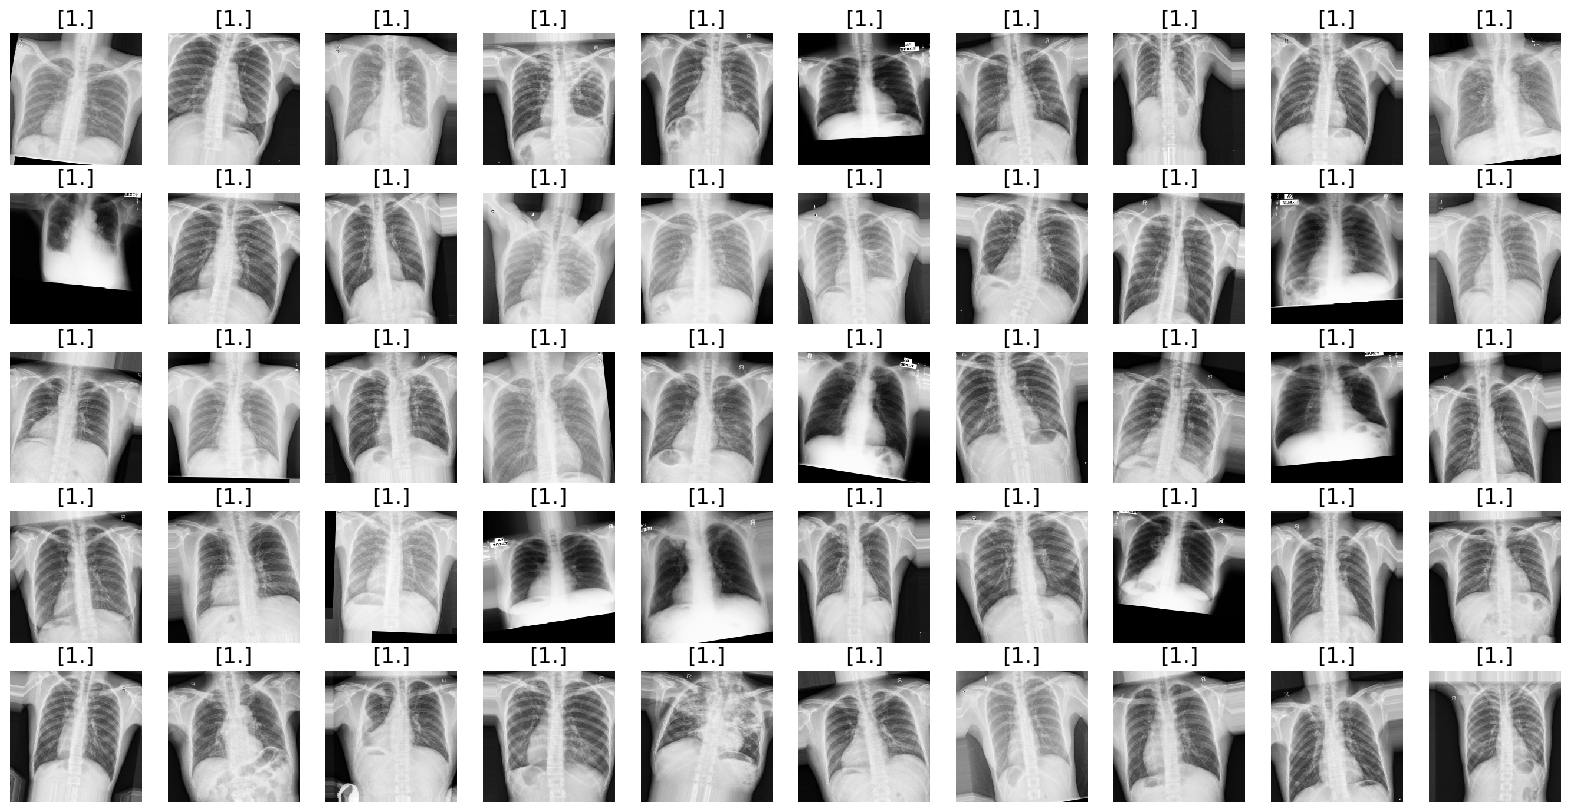

In [78]:
# Executa a função
plots(imgs, titles = labels) 

## Construção do Modelo

In [79]:
len(df_treino)

680

In [80]:
len(df_val)

120

In [81]:
# Número de exemplos de treinamento
num_amostras_treino = len(df_treino)

# Número de exemplos de validação
num_amostras_val = len(df_val)

# Tamanho do batch de treino
batch_size_treino = 10

# Tamanho do batch de validação
batch_size_val = 10

In [82]:
passos_treino = np.ceil(num_amostras_treino / batch_size_treino)
passos_val = np.ceil(num_amostras_val / batch_size_val)

## Geração de batchs
pelos motivos:
- Eficiência Computacional: Processar dados em lotes reduz o número de atualizações de parâmetros, tornando o treinamento mais eficiente e aproveitando melhor o hardware (especialmente GPUs).

- Estabilidade no Gradiente: Utilizar batches permite que o cálculo do gradiente seja baseado em múltiplos exemplos, reduzindo a variabilidade e tornando o processo de atualização mais estável e menos suscetível a ruídos.

- Melhor Uso da Memória: Treinar em batches permite processar grandes conjuntos de dados em partes menores, facilitando o uso em sistemas com limitações de memória.

In [83]:
datagen = ImageDataGenerator(rescale = 1.0/255)

gen_treino = datagen.flow_from_directory(dados_treino,
                                         target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                         batch_size = batch_size_treino,
                                         class_mode = 'categorical')

gen_val = datagen.flow_from_directory(dados_val,
                                      target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                      batch_size = batch_size_val,
                                      class_mode = 'categorical')

gen_teste = datagen.flow_from_directory(dados_val,
                                        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                        batch_size = batch_size_val,
                                        class_mode = 'categorical',
                                        shuffle = False)

Found 4000 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Definimos os hiperparâmetros que serão usados para treinar o modelo. Esses valores podem ser modificados para ajustar o modelo e tentar obter melhor precisão.

In [118]:
# Tamanho do kernel
kernel_size = (3,3)

# Tamanho do Pool
pool_size = (2,2)

num_neurons_1 = 32

num_neurons_2 = 64

num_neurons_3 = 128

num_neurons_4 = 256

num_neurons_5 = 512

# Taxa de dropout nas camadas de convolução
dropout_conv = 0.3

# Taxa de dropout na camada densa
dropout_dense = 0.3

# Taxa de aprendizado
taxa_aprendizado = 0.00001

# Número de épocas de treinamento
num_epochs = 70

In [119]:
# Arquitetura do Modelo

model = Sequential()

# Adicionamos a primeira camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_1, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Adicionamos a segunda camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_2, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Adicionamos a terceira camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_3, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Adicionamos a quarta camada convolucional com 3 operações de convolução
model.add(Conv2D(num_neurons_4, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_4, kernel_size, activation = 'relu'))
model.add(Conv2D(num_neurons_4, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Camada de "achatamento"
model.add(Flatten())

# Camada densa com dropout
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))

# Camada de saída
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 218, 218, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 107, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 105, 105, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 103, 103, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 51, 51, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 49, 49, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 47, 47, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,151,170 (23.46 MB)

 Trainable params: 6,151,170 (23.46 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# Compilação do modelo
model.compile(Adam(taxa_aprendizado), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [121]:
modelos_base_dir = '.'
modelos_dir = os.path.join(modelos_base_dir, 'modelos/')

dir_modelos = Path(modelos_dir)

if dir_modelos.exists():
    print('O diretório já existe. Delete no SO e tente novamente.')
else:
    os.mkdir(modelos_dir)

O diretório já existe. Delete no SO e tente novamente.


In [122]:
modelo_salvo = modelos_dir + 'modelo_raiox.keras'

In [123]:
checkpoint = ModelCheckpoint(modelo_salvo, 
                             monitor = 'val_accuracy', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

In [124]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 2, 
                              verbose = 1, 
                              mode = 'max',
                              min_lr = 0.0000001)

In [125]:
callbacks_list = [checkpoint, reduce_lr]

In [126]:
steps_per_epoch = int(passos_treino)
validation_steps = int(passos_val)
epochs = int(num_epochs)

## Treinamento do Modelo

In [127]:
%%time
history = model.fit(gen_treino,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=gen_val,
                    validation_steps=validation_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list
)

Epoch 1/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4842 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50833, saving model to .\modelos/modelo_raiox.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 263ms/step - accuracy: 0.4846 - loss: 0.6931 - val_accuracy: 0.5083 - val_loss: 0.6930 - learning_rate: 1.0000e-05
Epoch 2/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 244ms/step - accuracy: 0.5251 - loss: 0.6905 - learning_rate: 1.0000e-05
Epoch 3/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5323 - loss: 0.6904
Epoch 3: val_accuracy did not improve from 0.50833
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.5323 - loss: 0.6903 - val_accuracy: 0.5083 - val_loss: 0.6926 - learning_rate: 1.0000e-05
Epoch 4/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.5032 - loss: 0.6933 - learning_rate: 1.0000e-05
Epoch 5/70
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4978 - loss: 0.6915
Epoch 5: val_accuracy improved from 0.50833 to 0.55000, saving model to

In [128]:
# Obtém os nomes das métricas do modelo
model.metrics_names

['loss', 'compile_metrics']

In [129]:
# Carregamos o modelo treinado
model.load_weights('modelos/modelo_raiox.keras')

In [130]:
# Extraímos as métricas de treinamento
val_loss, val_acc = model.evaluate(gen_val, steps=validation_steps)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7348 - loss: 0.5791


In [131]:
# Imprimimos
print('\nErro do Modelo em Validação (val_loss):', val_loss)
print('Acurácia do Modelo em Validação (val_acc):', val_acc)


Erro do Modelo em Validação (val_loss): 0.5771647691726685
Acurácia do Modelo em Validação (val_acc): 0.7250000238418579


Vamos visualizar a curva de aprendizado.

In [132]:
# Extrai as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

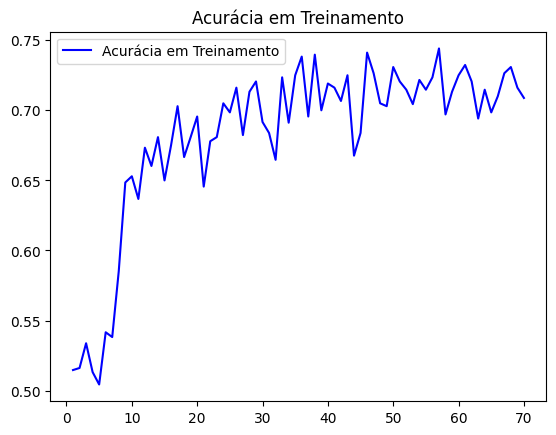

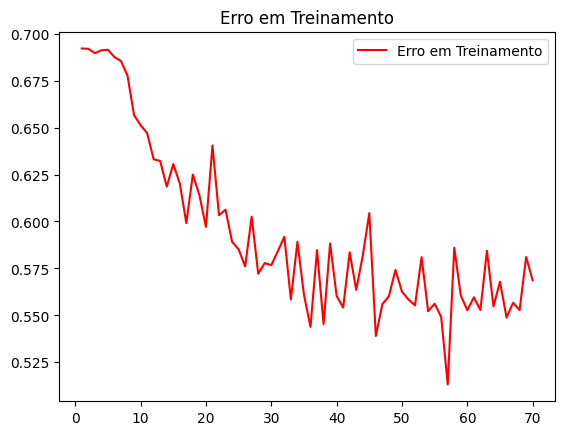

<Figure size 640x480 with 0 Axes>

In [133]:
# Plot

plt.plot(epochs, acc, '-', label = 'Acurácia em Treinamento', color = 'blue')
plt.title('Acurácia em Treinamento')
plt.legend()
plt.figure()

plt.plot(epochs, loss, '-', label = 'Erro em Treinamento', color = 'red')
plt.title('Erro em Treinamento')
plt.legend()
plt.figure()

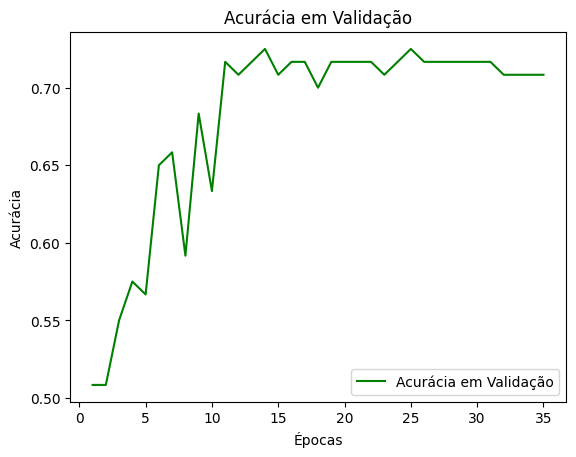

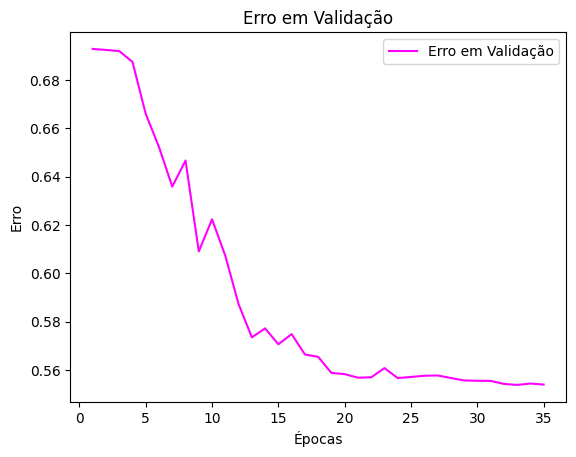

In [134]:
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, '-', label='Acurácia em Validação', color='green')
plt.title('Acurácia em Validação')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()

plt.plot(epochs, val_loss, '-', label='Erro em Validação', color='magenta')
plt.title('Erro em Validação')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.show()


In [135]:
# Vamos obter os labels dos dados de teste
labels_teste = gen_teste.classes

In [136]:
# Precisamos dos labels para o plot da matriz de confusão
labels_teste.shape

(120,)

In [137]:
# Imprimimos a etiqueta (label) associada a cada classe
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [138]:
# Fazemos as previsões
previsoes = model.predict(gen_teste, steps = validation_steps, verbose = 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [139]:
# Shape das previsões
previsoes.shape

(120, 2)

Vamos plotar uma Matriz de Confusão - Confusion Matrix.

In [140]:
# Função para a Matriz de Confusão
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.YlOrRd):

    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

In [141]:
matriz_conf = confusion_matrix(labels_teste, previsoes.argmax(axis = 1))

In [142]:
gen_teste.class_indices

{'Normal': 0, 'Tuberculose': 1}

In [143]:
matriz_conf_plot_labels = ['Normal', 'Tuberculose']

Matriz de Confusão Sem Normalização
[[38 23]
 [10 49]]


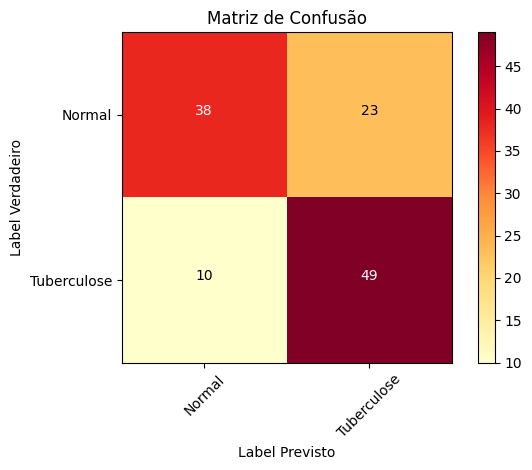

In [144]:
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusão')

In [145]:
imagens_teste = gen_teste.filenames

In [146]:
imagens_teste

['Normal\\CHNCXR_0006_0.png',
 'Normal\\CHNCXR_0012_0.png',
 'Normal\\CHNCXR_0019_0.png',
 'Normal\\CHNCXR_0023_0.png',
 'Normal\\CHNCXR_0025_0.png',
 'Normal\\CHNCXR_0028_0.png',
 'Normal\\CHNCXR_0030_0.png',
 'Normal\\CHNCXR_0035_0.png',
 'Normal\\CHNCXR_0037_0.png',
 'Normal\\CHNCXR_0041_0.png',
 'Normal\\CHNCXR_0042_0.png',
 'Normal\\CHNCXR_0047_0.png',
 'Normal\\CHNCXR_0048_0.png',
 'Normal\\CHNCXR_0057_0.png',
 'Normal\\CHNCXR_0061_0.png',
 'Normal\\CHNCXR_0073_0.png',
 'Normal\\CHNCXR_0081_0.png',
 'Normal\\CHNCXR_0082_0.png',
 'Normal\\CHNCXR_0086_0.png',
 'Normal\\CHNCXR_0110_0.png',
 'Normal\\CHNCXR_0114_0.png',
 'Normal\\CHNCXR_0118_0.png',
 'Normal\\CHNCXR_0122_0.png',
 'Normal\\CHNCXR_0139_0.png',
 'Normal\\CHNCXR_0154_0.png',
 'Normal\\CHNCXR_0165_0.png',
 'Normal\\CHNCXR_0166_0.png',
 'Normal\\CHNCXR_0176_0.png',
 'Normal\\CHNCXR_0177_0.png',
 'Normal\\CHNCXR_0179_0.png',
 'Normal\\CHNCXR_0181_0.png',
 'Normal\\CHNCXR_0182_0.png',
 'Normal\\CHNCXR_0196_0.png',
 'Normal\\

In [147]:
y_true = gen_teste.classes

In [148]:
y_pred = previsoes.argmax(axis=1)

Relatório de Classificação

In [149]:
from sklearn.metrics import classification_report

In [150]:
report = classification_report(y_true, y_pred, target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.79      0.62      0.70        61
 Tuberculose       0.68      0.83      0.75        59

    accuracy                           0.72       120
   macro avg       0.74      0.73      0.72       120
weighted avg       0.74      0.72      0.72       120



- Recall = Dada uma classe, o classificador será capaz de detectá-la?

- Precision = Dada uma previsão de classe, qual a probabilidade de estar correta?

- F1 Score = A média harmônica de Recall e Precision. Essencialmente, ele pune valores extremos.

# Fim